In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import cx_Oracle
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [71]:
df = pd.read_csv('data_q.csv')
df.head()

,MONTH,UNIT_CODE,MONTH_WORKS,RESULT_CHECK
0,2019/05,FC4260,7.0,0.638606
1,2019/05,FC4130,32.0,0.621353
2,2019/05,FC4129,32.0,0.620395
3,2019/05,FC4173,24.0,0.603339
4,2019/05,FC4050,50.0,0.591735


In [72]:
df = pd.read_csv('data_q.csv')
df_info = pd.read_excel('hr_raw.xlsx', sheet_name='Details')
df_info = df_info[['Mã Finone\n(Code bán hàng)', 'Loại nhân viên', 
                   'Khu vực','Trình độ chuyên môn',
                   'Ngày vào làm việc FC']]
df_info.columns = ['UNIT_CODE', 'staff_type', 'region', 'education', 'work_date']
df_info.head()

df = df.merge(df_info, how='left',left_on='UNIT_CODE', right_on='UNIT_CODE')
df.head()
df.work_date = pd.to_datetime(df.work_date, format='%Y=%m-%d')
df['work_months'] = round((pd.to_datetime(df.MONTH, format='%Y/%m') - 
                           pd.to_datetime(df.work_date, format='%Y=%m-%d')).dt.days/30)

df.loc[df['work_months'] < 0 , 'work_months'] = 0
df.head()

df = df[df['UNIT_CODE'].isin(df_info['UNIT_CODE'].to_list())]
df.head()

,MONTH,UNIT_CODE,MONTH_WORKS,RESULT_CHECK,staff_type,region,education,work_date,work_months
0,2019/05,FC4260,7.0,0.638606,NVCT,Central,Lao động phổ thông,2018-09-24,7.0
1,2019/05,FC4130,32.0,0.621353,NVCT,Central,Đại học,2016-09-01,32.0
2,2019/05,FC4129,32.0,0.620395,NVCT,Central,Đại học,2016-08-25,33.0
3,2019/05,FC4173,24.0,0.603339,NVCT,Central,Cao đẳng,2017-04-29,24.0
4,2019/05,FC4050,50.0,0.591735,NVCT,Central,Lao động phổ thông,2015-02-25,51.0


In [73]:
NBIN = 10 # số bin đã chia
shapex = 4 # số tháng lịch sử
shapey = 1 # số tháng tương lai

targets = [
    [[9,10],'20%'],
    [[8,9,10],'30%'],
]
cmap = palette=sns.color_palette("RdBu_r",NBIN)

In [74]:
def bin_data(df, nbin = 10):
    dt = pd.DataFrame()
    for month in sorted(df['MONTH'].unique()) :
        temp = df[df['MONTH'] == month]
        cuts = pd.qcut(temp['RESULT_CHECK'], q=nbin, precision=10).unique()
        for i,cut in enumerate(cuts.categories):
            temp.loc[(temp['RESULT_CHECK'] > cut.left) &(temp['RESULT_CHECK'] <= cut.right),'QUINTILE'] =  nbin - i 
        dt = dt.append(temp)
    dt.reset_index(drop=True, inplace=True)
    return dt

df = bin_data(df, nbin=NBIN)
print(df.shape)
df.head()

(12184, 10)


,MONTH,UNIT_CODE,MONTH_WORKS,RESULT_CHECK,staff_type,region,education,work_date,work_months,QUINTILE
0,2019/05,FC4260,7.0,0.638606,NVCT,Central,Lao động phổ thông,2018-09-24,7.0,1.0
1,2019/05,FC4130,32.0,0.621353,NVCT,Central,Đại học,2016-09-01,32.0,1.0
2,2019/05,FC4129,32.0,0.620395,NVCT,Central,Đại học,2016-08-25,33.0,1.0
3,2019/05,FC4173,24.0,0.603339,NVCT,Central,Cao đẳng,2017-04-29,24.0,1.0
4,2019/05,FC4050,50.0,0.591735,NVCT,Central,Lao động phổ thông,2015-02-25,51.0,1.0


In [75]:
# get month frame
def processings_data(fc_code='UNIT_CODE'):
    num_month = shapex + shapey
    data = pd.DataFrame()
    for i in range(num_month, len(df.MONTH.unique())+1):
        months = df.MONTH.unique()[i-num_month:i]
        t0_month = months[shapex-1]
        outmonths = months[-shapey:]
        # select exist 'UNIT_CODE_DESC'
        months_df = [df[df.MONTH == months[i]][fc_code].tolist() for i in range(shapex-1)] 
        for i, x in enumerate(months_df):
            if i == 0:
                fc_list = list(set(x)) 
            else: 
                fc_list = list(set(fc_list) & set(x))
        for i,month in enumerate(months):
            dt_temp = df[df.MONTH == month][[fc_code,'QUINTILE']]
            dt_temp.set_index(fc_code, inplace=True)
            col_name = f'QUINTILE_{i}'
            dt_temp.columns = [month]
            if i == 0:
                df_temp = dt_temp
            else:
                df_temp = pd.concat([df_temp, dt_temp], axis=1, sort=True)      
        df_temp['outcome'] = df_temp.loc[:, outmonths].mean(axis=1)
        df_temp.dropna(subset=months[:shapex], inplace=True)
        df_temp.drop(outmonths, axis=1, inplace=True)
        df_temp.columns = [f't-{i}' for i in range(shapex-1, -1, -1)]+['outcome']
        
        df_infotemp = df[df.MONTH == t0_month][[fc_code,'work_months']]                                               
        
        df_temp = df_temp.merge(df_infotemp, how='left',left_on=df_temp.index, right_on='UNIT_CODE')
        df_temp.drop(['UNIT_CODE'], axis=1, inplace=True)
        data = data.append(df_temp)
        #print(df_temp)
    data.reset_index(drop=True, inplace=True)
    #print(data.shape)
    data.fillna(NBIN, inplace=True)
    return data

data = processings_data()
print(data.shape)
print(data.head())

#for col in ['t-3','t-2','t-1','t-0']:
#    data[col+'_sqare'] = data[col]**2
data.head()

(7914, 6)
   t-3  t-2  t-1   t-0  outcome  work_months
0  5.0  5.0  2.0   6.0      7.0         54.0
1  6.0  8.0  6.0   9.0     10.0         54.0
2  1.0  2.0  3.0   5.0      3.0         54.0
3  9.0  9.0  6.0  10.0     10.0         54.0
4  4.0  3.0  1.0   5.0      5.0         54.0


,t-3,t-2,t-1,t-0,outcome,work_months
0,5.0,5.0,2.0,6.0,7.0,54.0
1,6.0,8.0,6.0,9.0,10.0,54.0
2,1.0,2.0,3.0,5.0,3.0,54.0
3,9.0,9.0,6.0,10.0,10.0,54.0
4,4.0,3.0,1.0,5.0,5.0,54.0


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc_cols = ['staff_type','education','region']
label_df = data[enc_cols]
label_df.isna().sum()
label_df.fillna('NULL',inplace = True)
enc.fit(label_df)
enc.get_feature_names(enc_cols)
onehot_data = pd.DataFrame(enc.transform(label_df).toarray(),
                   columns=enc.get_feature_names(enc_cols))
data = pd.concat([data.drop(enc_cols, axis=1), onehot_data],axis=1)
data.head()

In [76]:
#data = data[['t-2','t-2','t-1','t-0','outcome','work_months']]
print(data.shape)
data.head()

(7914, 6)


,t-3,t-2,t-1,t-0,outcome,work_months
0,5.0,5.0,2.0,6.0,7.0,54.0
1,6.0,8.0,6.0,9.0,10.0,54.0
2,1.0,2.0,3.0,5.0,3.0,54.0
3,9.0,9.0,6.0,10.0,10.0,54.0
4,4.0,3.0,1.0,5.0,5.0,54.0


# REGRESSION

In [77]:
from sklearn.model_selection import train_test_split

X = data.drop(['outcome'],axis=1)
y = data['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state = 15,
    stratify = y
)

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# define GridSearchCV
regressions = [
    [GridSearchCV(
        estimator=RandomForestRegressor(n_jobs=-1),param_grid={
            'n_estimators': [200, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [ 8,9,11,12,15,16],
        }, 
        scoring='r2', cv=3, n_jobs=-1), 
     "RF"],
    [GridSearchCV(
        estimator=SVR(), param_grid={
            'C': [1e0, 1e1, 1e2],
            'gamma': np.logspace(-2, 2, 5)
        }, scoring='r2', cv=3, n_jobs=-1), 
     "SVR"],
    [GridSearchCV(
        estimator=LinearRegression(), param_grid={
            'normalize': [False, True],
        }, scoring='r2', cv=3, n_jobs=-1), 
     "LR"],
]
# solver 
results = []
for reg in regressions:
    print(reg[0])
    reg[0].fit(X, y)
    results.append((reg[1], reg[0].best_score_, reg[0].best_params_))
results = pd.DataFrame(results, columns=['regression', 'r2', 'best_params']) 
results

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [8, 9, 11, 12, 15, 16]

,regression,r2,best_params
0,RF,0.353762,"{'max_depth': 8, 'max_features': 'log2', 'n_es..."
1,SVR,0.336871,"{'C': 1.0, 'gamma': 0.01}"
2,LR,0.370718,{'normalize': False}


# Function

In [87]:
def make_bins(pred, y_test, targets, quintile=10,):
    cuts = pd.qcut(pred,quintile,precision=8).unique()
    #print(cuts)
    df_probs = pd.DataFrame({'score' : pred,
                             'y' : y_test})
    cuts = pd.qcut(pred, quintile,precision=5).unique()
    for i,cut in enumerate(cuts.categories):
        left = 0 if i == 0 else cut.left
        right = quintile if i == quintile-1 else cut.right
        df_probs.loc[(df_probs.score > left) &(df_probs.score <= right),'bin'] =  i +1 
        df_probs.loc[(df_probs.score > left) &(df_probs.score <= right),'bin_value'] = cut
    df_probs.loc[df_probs.bin >quintile, 'bin'] = quintile
        
    total = df_probs.groupby('bin').agg(len)['score'] 
    df_range = pd.DataFrame({'total': total})
    for target in targets:
        df_probs[target[1]] = [1 if x in (target[0]) else 0 for x in  df_probs.y.tolist()]
        count_g = df_probs.groupby('bin').sum()[target[1]]/total * 100
        count_g.name = target[1]
        df_range = pd.concat([df_range, count_g], axis=1)

    fig, axs = plt.subplots(nrows = len(targets), figsize = (12,10), dpi=90,sharex=True)
    for i, ax, target in zip(range(len(targets)), axs, targets):
        ax.set_xlim(0,max(df_range[target[1]]) + 10)
        sns.barplot(x=df_range.index, y=target[1], data=df_range ,
                palette=cmap,hue=target[1],dodge=False,ax = ax)

        plus = 8 if i%2 == 0 else 1
        for xi,yi in zip(df_range.index-1,df_range[target[1]]):
            ax.text(xi-0.2, yi+2*i,str(round(yi,2))+ '%', fontweight='bold',fontsize = 8)
        ax.legend().remove()
        ax.set_title('Xác xuất rớt cut_off '+ target[1])
        mean = round(df_range.loc[target[0],target[1]].mean(),2)
        ax.annotate( f'cut off accuracy: {mean}%',
                    xy=(min(target[0])-1.5, yi*0.9), 
                    xytext=(min(target[0])-4.5, yi*0.9), 
                    arrowprops=dict(facecolor='black', shrink=0.05))
        x_range = [0] + list(df_range[target[1]])[1:]
        ax.axvline(x=min(target[0])-1.5, color='k')        
        ax.fill_betweenx(x_range,-1,min(target[0])-1.5, color=cmap[1], alpha=0.03)
        ax.fill_betweenx(x_range,min(target[0])-1.5,quintile, color=cmap[-1], alpha=0.15)
        #print(min(target[0]))
    if len(targets) == 2:
        axs[1].xaxis.tick_top()
        axs[1].invert_yaxis()
    return df_probs, df_range

In [92]:
def score_PN_rate(df_probs, iter_n=1.5):
    for i in np.arange(0, max(df_probs['score']), iter_n):
        df_probs.loc[(df_probs.score>=i)& (df_probs.score < i+iter_n), 'score_r'] = '%.1f-%.1f'%(i, i+iter_n) 
        #df_probs.loc[(df_probs.score>=i)& (df_probs.score < i+iter_n), 'min'] = i
    dts = []
    for target in targets:
        #print(target)
        x1=df_probs[df_probs.y.isin(target[0])].groupby(['score_r']).agg(len)[['y']]
        x1.columns = [target[1] +'P']
        x0=df_probs[~df_probs.y.isin(target[0])].groupby(['score_r']).agg(len)[['y']]
        x0.columns = [target[1] +'N']
        x = df_probs.groupby(['score_r']).agg(len)[['y']]
        x = x.merge(x1,how='left', on='score_r')
        x = x.merge(x0,how='left', on='score_r')
        #x.columns = ['count', 'P','N']
        x['P'] = x[target[1] +'P']/x['y'] * 100
        x['#'] = x['y'] * 100 / x['y'].sum()   
        x.fillna(0, inplace=True)
        #x.sort_index(ascending=True, inplace=True)
        dts.append(x)
    fig, axs = plt.subplots(ncols=len(targets)+1, figsize=(12,6), sharey=True, dpi=90)
    #x[['P']].plot.barh(ax = axs[1], width=0.2, color=cmap[1], alpha=0.5)
    dts[0][['#']].plot.barh(ax = axs[0], width=0.2, color=cmap[-1], alpha=0.5)
    #print(dts[0])
    #axs[0].invert_xaxis()
    axs[0].scatter(y=x.index, x=x['#'],color=cmap[-1], s=40)
    axs[0].yaxis.tick_right()
    axs[0].tick_params(axis='y',labelsize=7)    
    for yi,xi in enumerate(dts[0]['#'].tolist()):
        axs[0].text(xi, yi+0.2, '%.1f'%(xi) + '%', fontsize=6.5, fontweight='bold')
    # %P
    axs[0].get_legend().remove()  
    axs[0].set_xlabel('%')
    axs[0].set_title('% share')
    for i, ax in enumerate(axs[1:]):
        dts[i][['P']].plot.barh(ax = ax, width=0.2, color=cmap[1+i], alpha=0.7)
        ax.scatter(y=dts[i].index, x=dts[i]['P'],color=cmap[1+i], s=140)
        for yt, xt in enumerate(dts[i]['P'].tolist()):
            ax.text(xt, yt+0.2, '%.1f'%(xt) + '%', fontsize=7, fontweight='bold')   
        ax.get_legend().remove()       
        ax.set_title(f'xác xuất rớt {targets[i][1]}')

0.36975209730599623


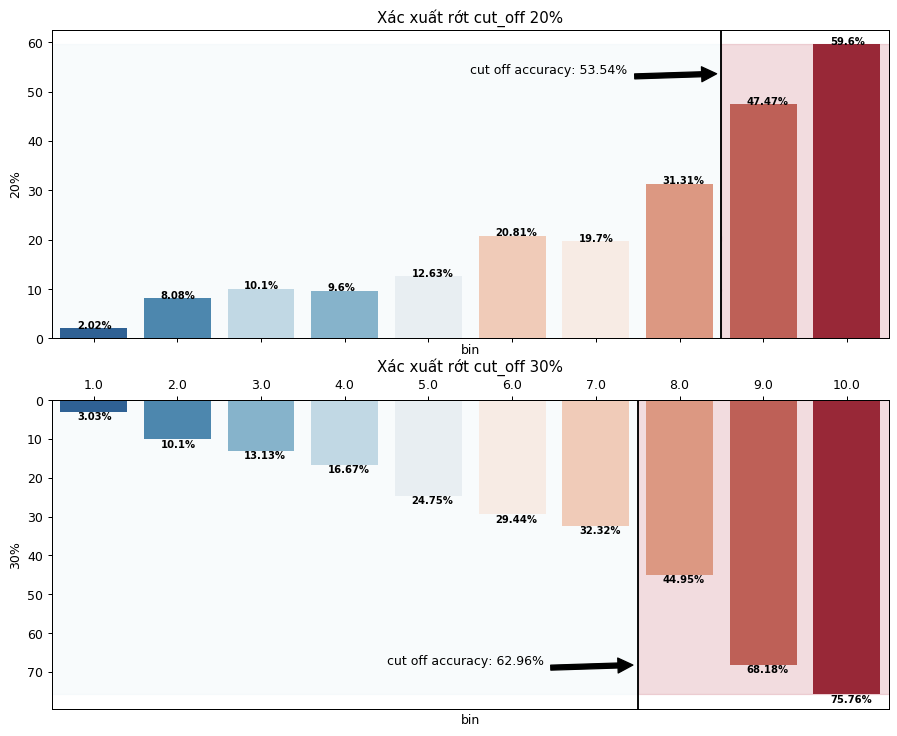

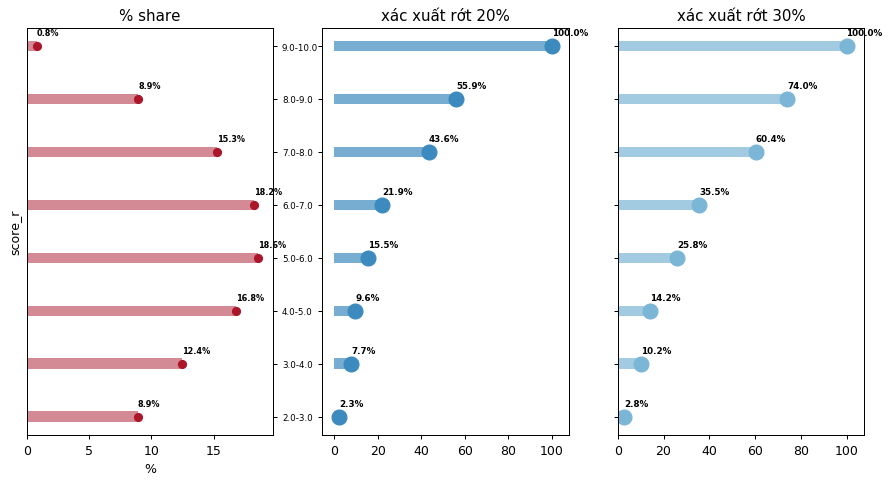

In [93]:
regr = RandomForestRegressor()
regr.set_params(**regressions[0][0].best_params_)
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print(regr.score(X_test, y_test))
pd.Series(pred).describe()
df_probs, df_range = make_bins(pred, y_test, targets, quintile=10)
score_PN_rate(df_probs, iter_n=1.0)

In [94]:
import statsmodels.api as sm      
X_train1 = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     715.8
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:10:10   Log-Likelihood:                -13402.
No. Observations:                5935   AIC:                         2.682e+04
Df Residuals:                    5929   BIC:                         2.686e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4486      0.090     16.044      

In [95]:
weight = [0.2, 0.2, 0.25, 0.35]
weight = [0.25, 0.25, 0.25, 0.25]

dataMA3 = data[data.columns.difference(['work_months'])].copy()
x = dataMA3[dataMA3.columns.difference(['outcome','work_months'])] * weight
dataMA3['wma'] = x.sum(axis=1)
dataMA3.head()

,outcome,t-0,t-1,t-2,t-3,wma
0,7.0,6.0,2.0,5.0,5.0,4.50
1,10.0,9.0,6.0,8.0,6.0,7.25
2,3.0,5.0,3.0,2.0,1.0,2.75
3,10.0,10.0,6.0,9.0,9.0,8.50
4,5.0,5.0,1.0,3.0,4.0,3.25


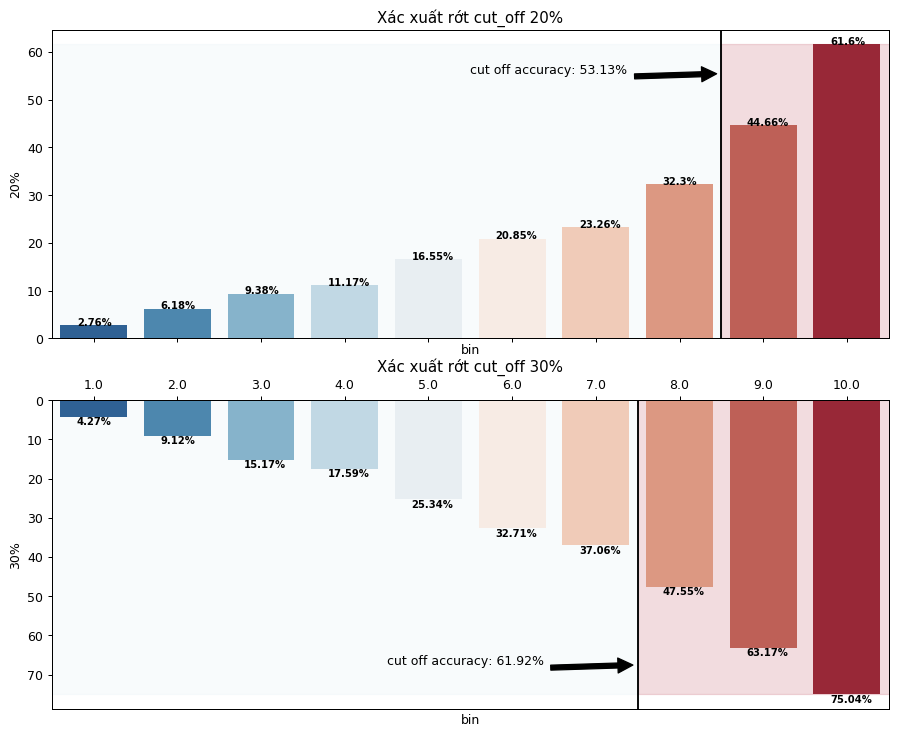

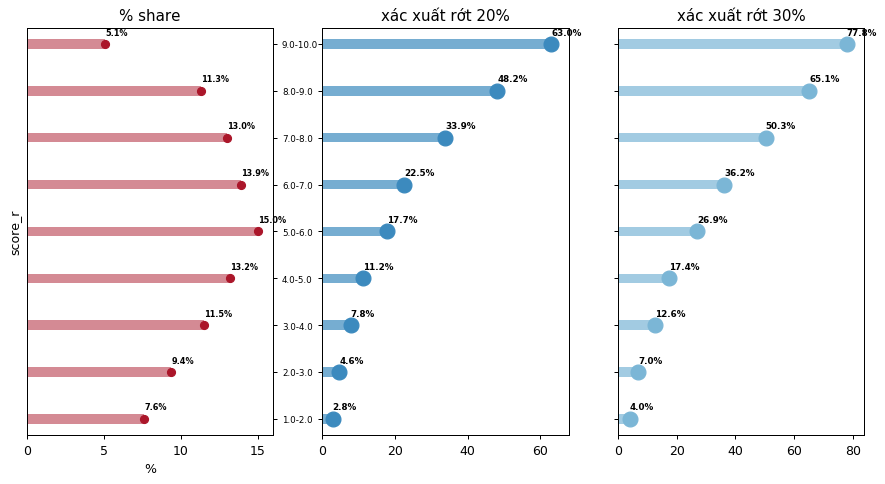

In [96]:
df_probsma, df_rangema = make_bins(dataMA3.wma, dataMA3.outcome, targets, quintile=10)
score_PN_rate(df_probsma, iter_n=1.0)

# CLASSIFI

In [109]:
target = targets[0]
data_c = data.copy()
#data_c.loc[data_c.outcome.isin(target[0]), 'cut_off'] = 1
#data_c.fillna(0, inplace=True)
#data_c.drop(['outcome'], axis=1, inplace=True)
data_c.head()

,t-3,t-2,t-1,t-0,outcome,work_months
0,5.0,5.0,2.0,6.0,7.0,54.0
1,6.0,8.0,6.0,9.0,10.0,54.0
2,1.0,2.0,3.0,5.0,3.0,54.0
3,9.0,9.0,6.0,10.0,10.0,54.0
4,4.0,3.0,1.0,5.0,5.0,54.0


In [121]:
X = data_c.drop(['outcome'],axis=1).values
y = np.array([1 if yi in target[0] else 0 for yi in data_c.outcome.tolist()])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state = 15,
    stratify = y
)

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [122]:
classifiers = [
    [GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), param_grid={
        'n_neighbors': [3, 7, 11]
    }, scoring='accuracy',cv=3, n_jobs=-1), "KNN"],
    [GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), param_grid={
        'n_estimators': [200, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [ 5,7,8,9],
        'criterion': ['gini', 'entropy']
    }, scoring='roc_auc', cv=3, n_jobs=-1), "RF"],
    [GridSearchCV(estimator=MLPClassifier(), param_grid={
        'solver': ['lbfgs'],
        'max_iter': [ 1500,2000],
        'alpha': 10.0 ** -np.arange(1, 3),
        'hidden_layer_sizes': np.arange(15, 20),
    }, scoring='roc_auc', cv=3, n_jobs=-1), "MLP"],
]

In [123]:
results = []
for clf in classifiers:
    clf[0].fit(X_train, y_train)
    results.append((clf[1], clf[0].best_score_, clf[0].best_params_))
results = pd.DataFrame(results, columns=['classifier', 'acc', 'best_params']) 
results

,classifier,acc,best_params
0,KNN,0.795992,{'n_neighbors': 11}
1,RF,0.789567,"{'criterion': 'entropy', 'max_depth': 5, 'max_..."
2,MLP,0.788724,"{'alpha': 0.1, 'hidden_layer_sizes': 16, 'max_..."


In [131]:
y_test

array([1, 0, 0, ..., 0, 0, 0])

In [143]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(max_depth=6, random_state=0,
                                    n_jobs=-1,n_estimators=200)

scores_from_cross = cross_val_score(rf, X_train, y_train, cv = 5,
                                    scoring="roc_auc", n_jobs = -1)
ginis = [x*2-1 for x in scores_from_cross]
print("cross validation gini :%.4f" %(np.mean(ginis)))

rf.fit(X_train, y_train)
def plot_im(n_im = 40):
    try:
        plt.figure()
        x= X_train.columns
        y = rf.feature_importances_
        im = pd.DataFrame({'x':x,'y':y})
        im.set_index('x', drop = True, inplace = True)
        im.sort_values('y', inplace = True,ascending=False)
        im = im[:n_im]
        fig, ax = plt.subplots(figsize = (8,6),dpi = 100 )
        im.plot.barh(ax = ax)
        ax.tick_params(axis='both', which='major', labelsize=7)
        plt.title('Feature Importances')
        plt.xlabel('Relative Importance')
        plt.show()
        return im
    except:
        pass
#im = plot_im(50)
print(im)

cross validation gini :0.5785
None


GINI: 0.5043842422273266 
Accuracy: 0.784 
F1: 0.3328998699609883
10.0    238
6.0     238
3.0     238
8.0     238
7.0     237
2.0     237
9.0     237
4.0     237
5.0     237
1.0     237
Name: bin, dtype: int64


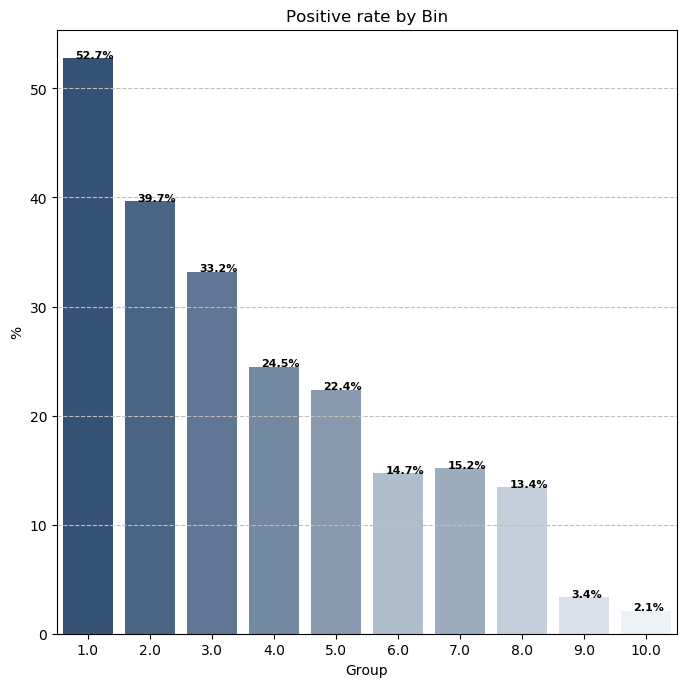

In [146]:
import pm_v2 as per
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred )
recall = recall_score(y_test, y_pred )
precision = precision_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
probs = rf.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test,probs)
gini = 2*auc - 1

print(f'GINI: {gini} \nAccuracy: {acc} \nF1: {f1}')

df_probs = pd.DataFrame({'score':probs})
df_probs , df_range ,cuts = per.probs_to_bins_per(
    df_probs,
    y_test, 10,
    label_Pos='Paid',
    dpi=100,
    color='#2b5281'
)